In [65]:
import numpy as np
import rasterio as rio
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [66]:
bathymetry = rio.open('data/bathymetry1.tif')

In [67]:
print('{} opened in {} mode'.format(bathymetry.name,bathymetry.mode))
print('image has {} band(s)'.format(bathymetry.count))
print('image size (width, height): {} x {}'.format(bathymetry.width, bathymetry.height))
print('band 1 dataype is {}'.format(bathymetry.dtypes[0])) # note that the band name (Band 1) differs from the list index [0]

data/bathymetry1.tif opened in r mode
image has 1 band(s)
image size (width, height): 11261 x 9342
band 1 dataype is float32


In [68]:
img = bathymetry.read()

In [69]:
centeri, centerj = bathymetry.height // 2, bathymetry.width // 2 # note that centeri corresponds to the row, and centerj the column
centerx, centery = bathymetry.transform * (centerj, centeri) # note the reversal here, from i,j to j,i
print(bathymetry.index(centerx, centery))
print((centeri, centerj) == bathymetry.index(centerx, centery)) # check that these are the same

(4671, 5630)
True


In [70]:
top, lft = bathymetry.index(centerx-500, centery+500)
bot, rgt = bathymetry.index(centerx+500, centery-500)

subset = bathymetry.read(window=((top, bot), (lft, rgt))) # format is (top, bottom), (left, right)

bathymetry.close() # remember to close the dataset now that we're done with it.

In [71]:
with rio.open('data/bathymetry1.tif') as Sediment:
    img = Sediment.read()
    xmin, ymin, xmax, ymax = Sediment.bounds

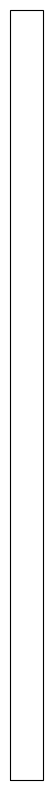

In [72]:
myCRS = ccrs.UTM(29) # note that this matches with the CRS of our image
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection=myCRS))

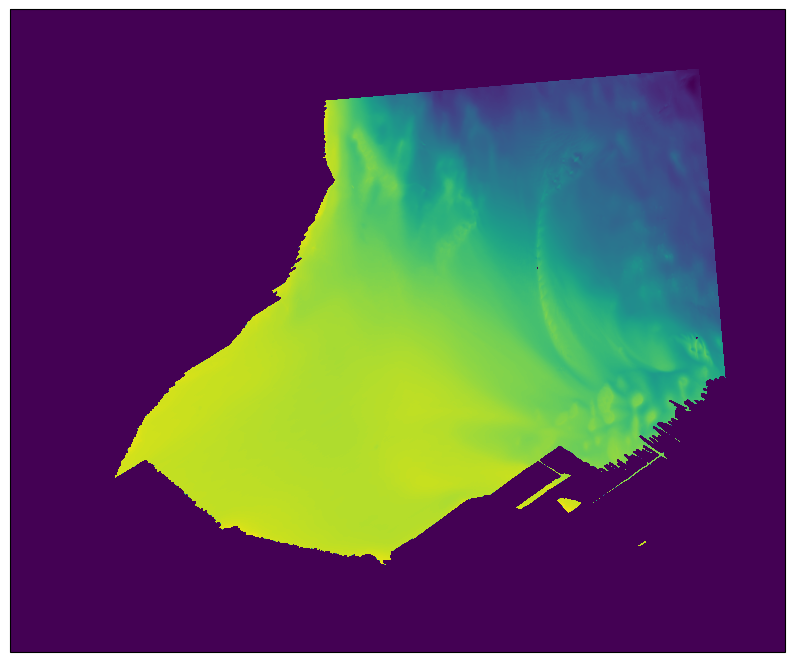

In [74]:
ax.imshow(img[0], cmap='viridis', vmin=-98, vmax=2)

fig

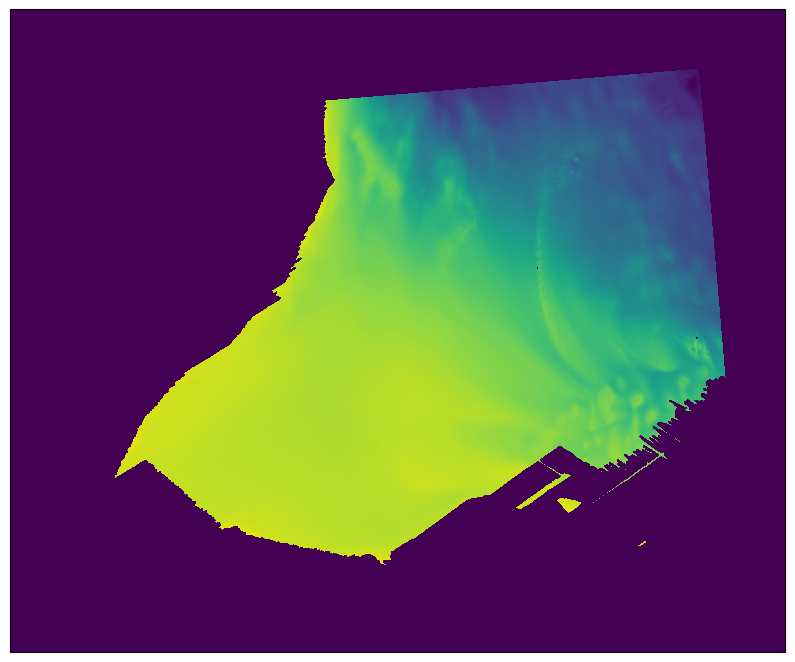

In [75]:
ax.imshow(img[0], cmap='viridis', vmin=-98, vmax=2, transform=myCRS, extent=[xmin, xmax, ymin, ymax])

fig

In [76]:
def img_display(image, ax, bands, transform, extent):
    '''
    This is where you should write a docstring.
    '''
    # first, we transpose the image to re-order the indices
    dispimg = image.transpose([1, 2, 0])
    
    # next, we have to scale the image.
    dispimg = dispimg / dispimg.max()
    
    # finally, we display the image
    handle = ax.imshow(dispimg[:, :, bands], transform=transform, extent=extent)
    
    return handle, ax

In [77]:
def percentile_stretch(image, pmin=0., pmax=100.):
    '''
    This is where you should write a docstring.
    '''
    # here, we make sure that pmin < pmax, and that they are between 0, 100
    if not 0 <= pmin < pmax <= 100:
        raise ValueError('0 <= pmin < pmax <= 100')
    # here, we make sure that the image is only 2-dimensional
    if not image.ndim == 2:
        raise ValueError('Image can only have two dimensions (row, column)')
    
    minval = np.percentile(image, pmin)
    maxval = np.percentile(image, pmax)
    
    stretched = (image - minval) / (maxval - minval) # stretch the image to 0, 1
    stretched[image < minval] = 0 # set anything less than minval to the new minimum, 0.
    stretched[image > maxval] = 1 # set anything greater than maxval to the new maximum, 1.
    
    return stretched

In [78]:
def img_display(image, ax, bands, transform, extent, pmin=0, pmax=100):
    '''
    This is where you should write a docstring.
    '''
    dispimg = image.copy().astype(np.float32) # make a copy of the original image,
    # but be sure to cast it as a floating-point image, rather than an integer

    for b in range(image.shape[0]): # loop over each band, stretching using percentile_stretch()
        dispimg[b] = percentile_stretch(image[b], pmin=pmin, pmax=pmax)

    # next, we transpose the image to re-order the indices
    dispimg = dispimg.transpose([1, 2, 0])
    
    # finally, we display the image
    handle = ax.imshow(dispimg[:, :, bands], transform=transform, extent=extent)
    
    return handle, ax

In [79]:
h, ax = img_display(img, ax, [0], myCRS, [xmin, xmax, ymin, ymax], pmin=0.1, pmax=99.9)
fig # just to save you from scrolling back up to see

MemoryError: Unable to allocate 803. MiB for an array with shape (9342, 11261) and data type float64